# Importing Libraries and the Image

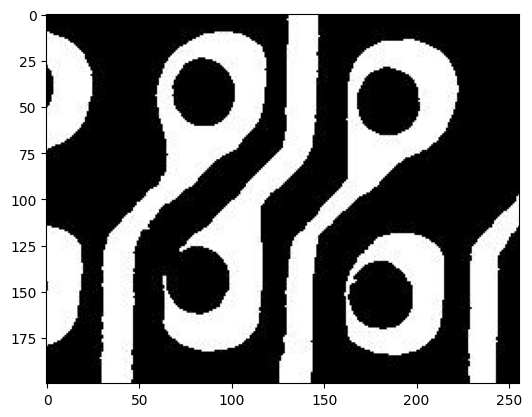

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read the input image
img = cv2.imread('/Images/holes.jpg')

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Original image
plt.imshow(img)
plt.show()

# Method 1 : Morphology and cv2.findContours

Here we perform morphological closing on the image for different kernel sizes ranging from 30 to 40. For each kernel size, we create a circular structuring element of that size and perform morphological closing on the input image using that structuring element. Then compute the absolute difference between the current and previous filltered images then we take use of the morphological closing to realize if there exists a circle simillar to the current circular structureing element; if so a circle with the diameter of current kernel size is considered to have been found. We then find contours in the processed image(the original image, closed with the current kernel and opened with the previous kernel), draw the contours around the detected circles, and display the processed image with the detected holes and their diameters.

The reliability of this method is limited because it only searches for circles in a narrow range of kernel sizes. If we extend the search range beyond the current range, we may encounter unexpected results.

diameter:  34  pixels


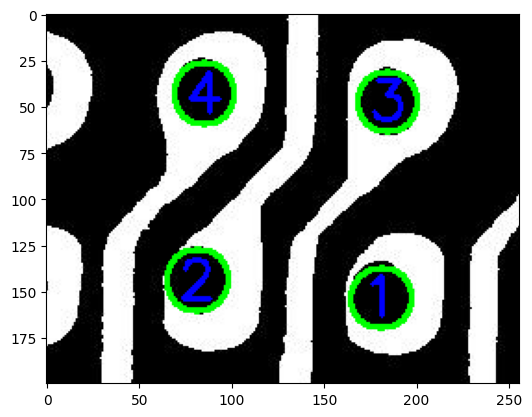

In [ ]:
# Define the range of kernel sizes to be tested
kernel_sizes = range(30, 40, 1)

# Initialize variables to store the previous image and kernel size
prev_img = None
prev_kernel = None

# Loop over the kernel sizes
for ksize in kernel_sizes:
    # Create a circular structuring element of the current size
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (ksize, ksize))

    # Perform morphological closing
    closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)

    # If this is not the first iteration, compare the result with the previous one
    if prev_img is not None:
        # Compute the absolute difference between the current and previous images
        diff = cv2.absdiff(closing, prev_img)
        opening_diff = cv2.threshold(cv2.morphologyEx(diff, cv2.MORPH_OPEN, kernel), 50, 255, cv2.THRESH_BINARY)[1]
        pre_opening_diff = cv2.threshold(cv2.morphologyEx(diff, cv2.MORPH_OPEN, prev_kernel), 50, 255, cv2.THRESH_BINARY)[1]

        if not np.array_equal(opening_diff, pre_opening_diff):
            print('diameter: ', ksize, ' pixels')
            # Find contours in the processed image
            gray_ = cv2.cvtColor(pre_opening_diff, cv2.COLOR_BGR2GRAY)
            gray_8bit = cv2.convertScaleAbs(gray_)
            _, thresh_ = cv2.threshold(gray_8bit, 127, 255, cv2.THRESH_BINARY)
            contours, hierarchy = cv2.findContours(thresh_, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # display the processed image with the detected holes and their diameters
            output = img.copy()
            cv2.drawContours(output, contours, -1, (0, 255, 0), 2)
            for i, cnt in enumerate(contours):
                area = cv2.contourArea(cnt)
                (x, y), _ = cv2.minEnclosingCircle(cnt)
                cv2.putText(output, "{}".format(i+1), (int(x)-10, int(y)+10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
            plt.imshow(output)
            plt.show()

    # Store the current result and kernel size for the next iteration
    prev_img = closing
    prev_kernel = kernel

# Method 2: Morphology and Hough Transform

In this method, the program performs circle detection on the input image using OpenCV. Firstly, morphological closing is applied on the grayscale image to fill small gaps using an elliptical kernel of size 20x20. Then, the HoughCircles method is used to detect circles in the processed image. The parameters for HoughCircles are set to a minimum and maximum radius of 1 and 40, respectively, and a gradient-based method is used for circle detection. If circles are detected, they are drawn on a copy of the original image along with a small circle at the center and the diameter is printed for each circle. The final image with the detected circles and their diameters is then displayed using matplotlib.

I have adjusted the kernel size used for morphological closing in order to optimize the filtering of the input image. This will allow the Hough transform algorithm to detect all of the circles present in the image.

hole count:  4
Diameter of circle at (184, 46): 34
Diameter of circle at (182, 152): 36
Diameter of circle at (82, 146): 34
Diameter of circle at (86, 42): 32


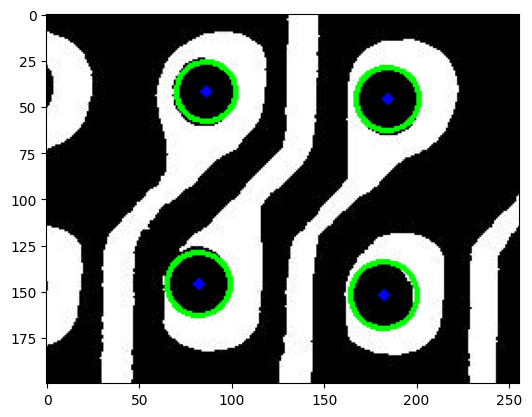

In [ ]:
# Perform morphological closing to fill small gaps.
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20,20))
closing = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)

# Apply Hough transform on the blurred image.
detected_circles = cv2.HoughCircles(closing, cv2.HOUGH_GRADIENT, 1, 20, param1 = 50, param2 = 30, minRadius = 1, maxRadius = 40)

# Draw circles that are detected.
if detected_circles is not None:

    # Convert the circle parameters a, b and r to integers.
    detected_circles = np.uint16(np.around(detected_circles))
    print('hole count: ', len(detected_circles[0]))
    output = img.copy()

    for pt in detected_circles[0, :]:
        a, b, r = pt[0], pt[1], pt[2]

        # Draw the circumference of the circle.
        cv2.circle(output, (a, b), r, (0, 255, 0), 2)

        # Draw a small circle (of radius 1) to show the center.
        cv2.circle(output, (a, b), 1, (0, 0, 255), 3)
        # Print the diameter.
        diameter = 2*r
        print("Diameter of circle at ({}, {}): {}".format(a, b, diameter))

    plt.imshow(output)
    plt.show()